In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import sklearn
# fix random seed for reproducibility
np.random.seed(7)

from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima as pm
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose

ROOT = "C:/Users/"

# MODELO CON ARIMA

Este cuaderno va a tratar de aprovechar los algoritmos ARIMA, SARIMA y SARIMAX para poder realizar una predicción. Como todo predictor de Time Series, emplea los resultados anteriores para poder predecir los siguientes, al igual que los demás algoritmos y esto será un por la misma razón que en el caso de TBATS.

Los siguientes enlaces contienen guías que explican bien el método:

- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd
- https://towardsdatascience.com/facing-the-arima-model-against-neural-networks-745ba5a933ca

Enlace a un video explicativo de implementación de ARIMA:

- https://www.machinelearningplus.com/arima/implement-arima-model/

In [2]:
# funcion para el split
def divide(df, proporcion = 0.75):
    corte = round(len(df)*proporcion)
    train = df[:corte]
    test = df[corte:]
    return train, test

# metricas de performance
def forecast_accuracy(forecast, actual):
    #=============================================================== AÑADIDO PARA DIFERENTES ARRAY
    if (len(forecast) != len(actual)):
        if (len(forecast) < len(actual)):
            actual = actual[:len(forecast)]
        else:
            forecast = forecast[:len(actual)]
    #===============================================================
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual)) # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual) / actual) # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]  # corr
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis = 1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis = 1)
    minmax = 1 - np.mean(mins / maxs)           # minmax
    acf1 = acf(forecast - actual)[1]            # autocorrelacion del error, primer lag
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 'corr':corr, 'minmax':minmax})

Código extraído del cuaderno del estudio de datos.

In [3]:
# los tres dataset
df_clientes = pd.read_csv(ROOT + ".csv", delimiter = ',')
df_dim_pedidos = pd.read_csv(ROOT + ".csv", delimiter = ',')
df_pedidos = pd.read_csv(ROOT + ".csv", delimiter = ',')
df_clientes = df_clientes.dropna()
df_dim_pedidos = df_dim_pedidos.dropna()
df_pedidos = df_pedidos.dropna()

# selecciona el id y la cantidad de pedidos en tabla auxiliar
df_aux = pd.DataFrame()
df_aux['cantidad'] = df_pedidos.groupby('digit_digit_sm_idpedido')['digit_digit_sm_cantidad'].sum()
df_aux = df_aux.reset_index() # groupby convierte la variable clave en index, por lo que hay que desconvertir

# crea un dataframe para unirlo todo
df = pd.DataFrame()
df['timestamp'] = pd.to_datetime(df_dim_pedidos['digit_digit_sm_fechapedido']) # extrae fechas
df = df[df['timestamp'] > '2015-01-01'] # a partir del año del comportamiento actual
#df = df[df['timestamp'] < '2021-06-01'] # omitiendo los picos de ventas post-covid
df['id_pedido'] = df_dim_pedidos['digit_digit_sm_idpedido'] # extrae id para añadir la informacion del pedido
df = df.join(df_aux.set_index('digit_digit_sm_idpedido'), on = 'id_pedido') # añade informacion de pedido
df = df.drop(['id_pedido'], axis = 1) # elimina la columna auxiliar de los pedidos
df = df.sort_values(by = 'timestamp', ascending = True) # ordena segun el timestamp
#df['crisis_oferta'] = 0 # Se va a crear una columna de crisis de oferta para intentar reflejar el efecto del covid
#df['crisis_oferta'].loc[(df['timestamp'] > '2020-03-14') & (df['timestamp'] < '2021-05-01')] = 1
df['week'] = df['timestamp'].dt.isocalendar().week # una columna con la semana del año
df['year'] = df['timestamp'].dt.year # una columna por año
df = df.set_index(['week', 'year']) # establece semanas y años de index para agrupar segun ellos
df['cantidad'] = df.groupby(['week', 'year'])['cantidad'].sum() # agrupa los pedidos que se produjeron la misma semana del año
df = df[~ df.index.duplicated(keep = 'first')] # elimina las replicas que se han producido en la agrupacion anterior
df = df.reset_index().set_index(['timestamp']) # cambia timestamp de index
df = df.drop(['week', 'year'], axis = 1) # elimina las columnas innecesarias
df['cantidad'] = df['cantidad'].rolling(1, center = True, closed = 'both').mean() # suavizado mediante Moving Average
# elimina nan
print(df.shape)
df = df.dropna()
print(df.shape)
df = df[df['cantidad'] > 0] # elimina negativos y ceros para poder aplicar seasonal
df['cantidad'] = df['cantidad'].rolling(1, center = True, closed = 'both').mean() # suavizado mediante Moving Average
df

(362, 1)
(362, 1)


,cantidad
timestamp,
2015-01-02,4665.00
2015-01-06,7207.00
2015-01-12,11633.50
2015-01-19,12848.25
2015-01-26,11710.00
...,...
2021-11-01,16430.00
2021-11-10,8274.50
2021-12-01,11358.25


- Para el caso de los modelos S-ARIMA-X es esencial entender la naturaleza del modelo mediante el Augmented Dickey Fuller Test y los test de autocorrelación posteriores ya que de esta depende el método que se vaya a emplear.

In [7]:
# Se necesita diferenciacion solo si el comportamiento es no estacionario (d = 0)
result = adfuller(df['cantidad'], autolag = 'AIC')
if result[1] > 0.05:
    print('Según ADF, el modelo es no estacionario')
else:
    print('Según ADF, el modelo es estacionario')
    
# KPSS Test
# Otra opinión.
result = kpss(df['cantidad'], regression = 'c')
if result[1] > 0.05: # Si el P-value es no significativo
    print('Según KPSS, el modelo es estacionario')
else:
    print('Según KPSS, el modelo es no estacionario')

Según ADF, el modelo es estacionario
Según KPSS, el modelo es estacionario


D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# =============================================================

### Estudio de las componentes del comportamiento del modelo

Los términos dpq (ARIMA):
- p (AR); el coeficiente autoregresivo indica el número de atrasos o lags de **$Y$** que son susceptibles de ser predictores. La parte autorregresiva es expresada como las Y en la ecuación de ARIMA. Si no se produce autorregresión el modelo, su orden será 0.

- d (I); el Integrator que es un número que expresa la cantidad mínima de diferenciaciones necesarias para hacer la tendencia estacionaria, y si ya lo es, su valor será de orden 0.

- q (MA); refiere al término moving average que se refiere al número de errores **${\epsilon}$** en el retraso de la predicción. Se expresa en la parte de la regresión lineal en la ecuación de ARIMA.

**$$Y_t = {\alpha} + {\beta}_{1}Y_{t-1} + {\beta}_{2}Y_{t-2} + ... + {\beta}_{p}Y_{t-p}{\epsilon}_{t} + {\phi}_{1}{\epsilon}_{t-1} + {\phi}_{2}{\epsilon}_{t-2} + ... + {\phi}_{q}{\epsilon}_{t-q}$$**

Ya que ARIMA se trata de una regresión y se producen correlaciones por la propia autocorrelación. Necesita diferenciar los valores previos del valor actual y esta diferenciación depende de la complejidad del modelo de estudio.

##### Orden del término I (D):

El propósito de diferenciar cada punto del modelo con su inmediato anterior es el de volverlo estacionario. El orden correcto de diferenciación es el mínimo necesario para obtener una serie casi estacionaria. Esto es, que ronde una media y los lags de la gráfica de autocorrelación alcancen el 0 lo antes posible.

- Si hay varios lags positivos con una tendencia coherente a parte del primero en la gráfica, está subdiferenciado.
- Si por lo menos el primer lag es negativo, entonces está sobrediferenciado.
- En caso de duda entre órdenes, se debe escoger el que reduzca al mínimo la desviación estándar en la diferenciación y no tenga valores negativos destacables.

Como previamente se ha comprobado, este modelo se va a considerar estacionario y **el orden va a ser 0** a pesar de su ligera autocorrelación, esto va a ser comprobado gráficamente. Como se aprecia en la primera autocorrelación, aún existen valores positivos, en el siguiente orden se estabiliza, pero adquiere valores negativos, con lo que sería preferible mantener el orden 0.

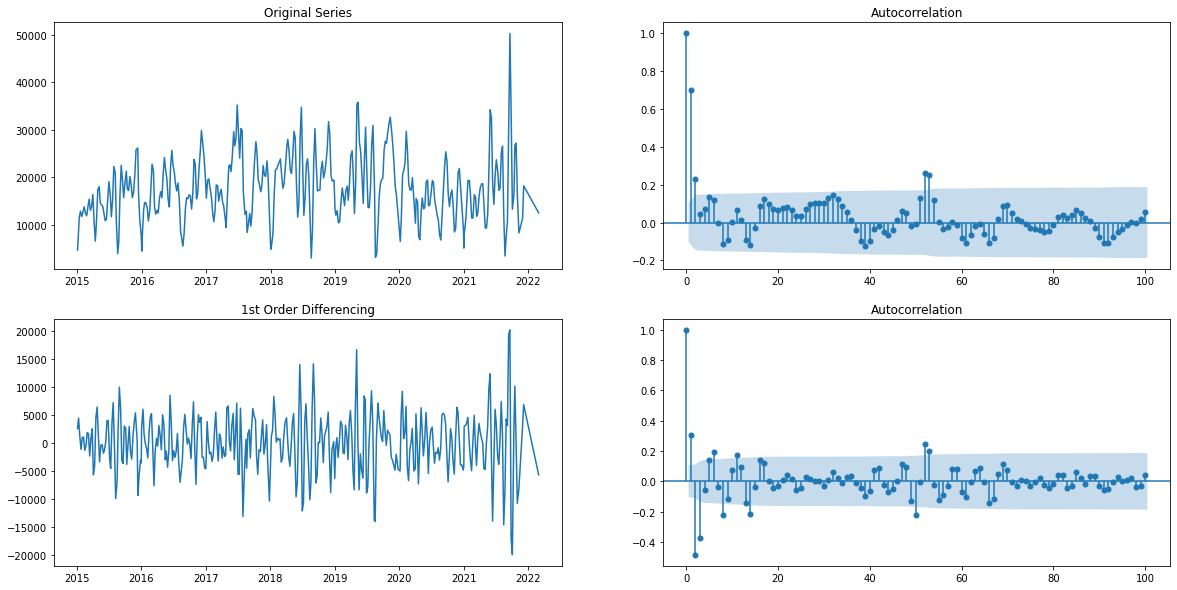

In [8]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10))
# Original Series
ax[0, 0].plot(df['cantidad']); ax[0, 0].set_title('Original Series')
plot_acf(df['cantidad'], lags = 100, ax = ax[0, 1])

# 1st Differencing
ax[1, 0].plot(df['cantidad'].diff()); ax[1, 0].set_title('1st Order Differencing')
plot_acf(df['cantidad'].diff().dropna(), lags = 100, ax = ax[1, 1]) # Primera diferenciación, sólo un diff().

plt.show()

##### Orden del término AR (P):

Igual que con el estudio de la estacionalidad, la autocorrelación necesita de la diferenciación entre lags, aunque en este caso con estudio en la autocorrelación parcial.

La autocorrelación parcial excluye el efecto de los otros lags a parte del de estudio, dejando un estudio de correlación puro entre los dos lags. Si se desea estudiar el efecto de cada lag para entender hasta donde llega la autocorrelación (o sea, el orden de AR), se tienen que estudiar por separado para saber cuántas autocorrelaciones se tienen que rectificar.

El orden de rectificación llega hasta donde la gráfica de autocorrelación parcial no tenga muchos lags por encima de la tendencia y en este caso se ignoran los lags negativos. En este caso queda en el **segundo orden** ya que el único lag que sobresale al principio es muy pequeño.

D:\Python\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


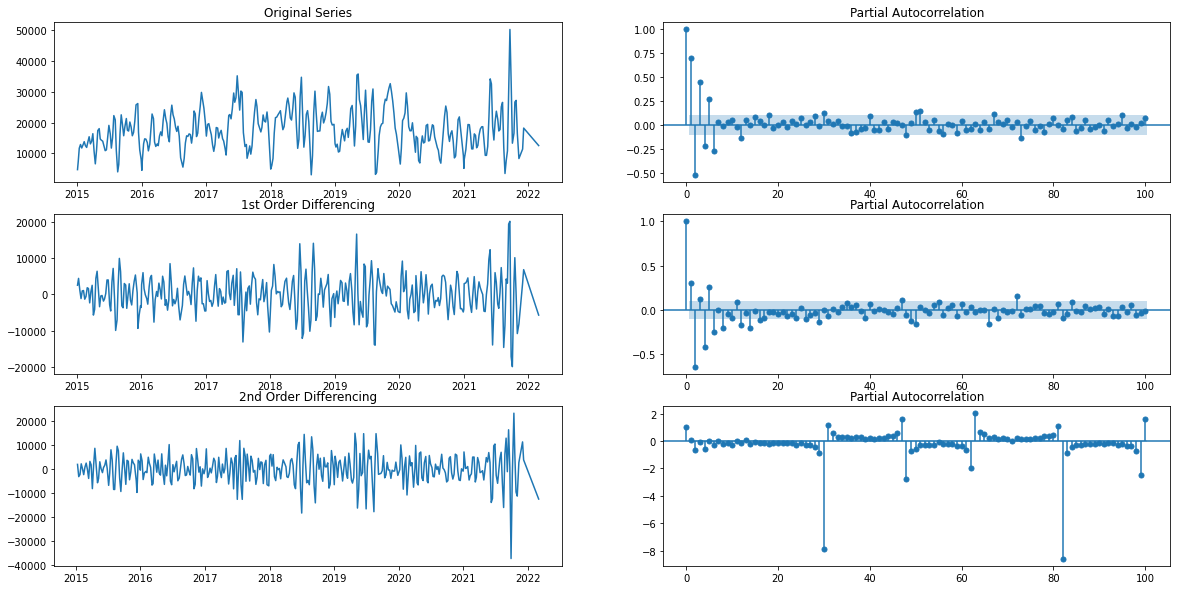

In [9]:
fig, ax = plt.subplots(3, 2, figsize = (20, 10))
# Original Series
ax[0, 0].plot(df['cantidad']); ax[0, 0].set_title('Original Series')
plot_pacf(df['cantidad'], lags = 100, ax = ax[0, 1])

# 1st Differencing
ax[1, 0].plot(df['cantidad'].diff()); ax[1, 0].set_title('1st Order Differencing')
plot_pacf(df['cantidad'].diff().dropna(), lags = 100, ax = ax[1, 1]) # Primera diferenciación, sólo un diff().

# 2nd Differencing
ax[2, 0].plot(df['cantidad'].diff().diff()); ax[2, 0].set_title('2nd Order Differencing')
plot_pacf(df['cantidad'].diff().diff().dropna(), lags = 100, ax = ax[2, 1]) # Segunda diferenciación, dos diff().

plt.show()

##### Orden del término MA (Q):

La autocorrelación normal expresa el número de coeficientes de errores. Para este caso no se tienen en cuenta los valores negativos, sino que haya muchos lags por encima de la tendencia. Si bien en el segundo orden todavía quedan algunos valores positivos, sería prudente estudiar la tendencia con orden 0 y 1.

Si la serie está ligeramente subdiferenciada (orden 0), podría optarse por añadir un grado más a MA. Diferenciarla una vez más podría sobrediferenciarla (1), por lo que podría añadirse un grado más a AR.

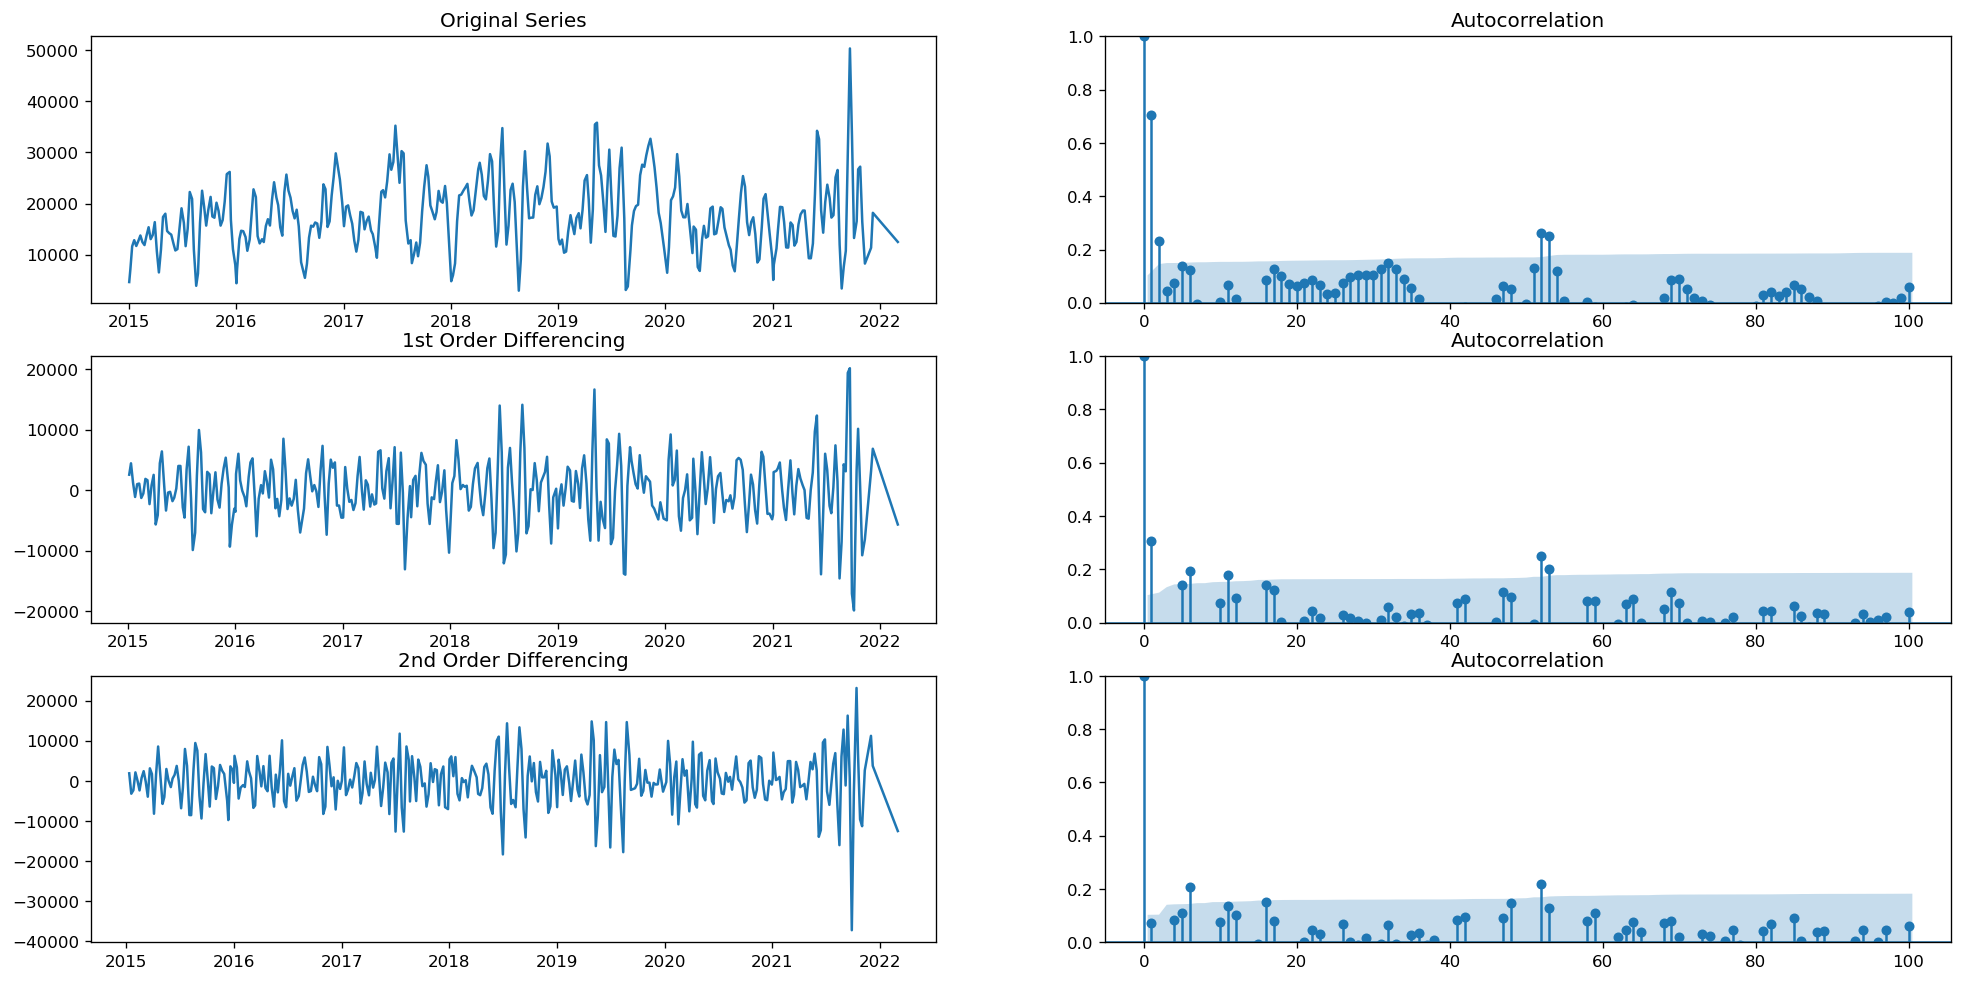

In [10]:
plt.rcParams.update({'figure.figsize':(9, 3), 'figure.dpi':120})
fig, ax = plt.subplots(3, 2, figsize = (20, 10))

# Original Series
ax[0, 0].plot(df['cantidad']); ax[0, 0].set_title('Original Series')
ax[0, 1].set(ylim = (0., 1)) # Muestra solo lo positivo.
plot_acf(df['cantidad'], lags = 100, ax = ax[0, 1])

# 1st Differencing
ax[1, 0].plot(df['cantidad'].diff()); ax[1, 0].set_title('1st Order Differencing')
ax[1, 1].set(ylim = (0., 1))
plot_acf(df['cantidad'].diff().dropna(), lags = 100, ax = ax[1, 1]) # Primera diferenciación, sólo un diff().

# 2nd Differencing
ax[2, 0].plot(df['cantidad'].diff().diff()); ax[2, 0].set_title('2nd Order Differencing')
ax[2, 1].set(ylim = (0., 1))
plot_acf(df['cantidad'].diff().diff().dropna(), lags = 100, ax = ax[2, 1]) # Segunda diferenciación, dos diff().

plt.show()

# =============================================================


### Implementación de ARIMA

El problema de ARIMA y nada más es que carece de estudio de estacionalidad, por lo que solamente se acabaría expresando la tendencia del modelo estacional. Sin embargo, es interesante representar la predicción para probar lo dicho previamente;

In [25]:
# Subiendo de orden de 2 a 3 el primer valor (AR) para compensar la subdiferenciación previamente comentada.
model = ARIMA(df['cantidad'], order = (3, 0, 0))
model_fit = model.fit(disp = 0)
print(model_fit.summary())

D:\Python\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

                              ARMA Model Results                              
Dep. Variable:               cantidad   No. Observations:                  362
Model:                     ARMA(3, 0)   Log Likelihood               -3476.457
Method:                       css-mle   S.D. of innovations           3574.524
Date:                Wed, 03 Aug 2022   AIC                           6962.915
Time:                        04:07:23   BIC                           6982.373
Sample:                             0   HQIC                          6970.650
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            1.76e+04    807.089     21.809      0.000     1.6e+04    1.92e+04
ar.L1.cantidad     1.3392      0.047     28.727      0.000       1.248       1.431
ar.L2.cantidad    -1.0470      0.064

Al representar los residuos producidos por el modelo, se aprecia como estos oscilan alrededor del 0 de manera homogénea. Esto podría indicar que no hay información perdida sin explicar del propio comportamiento del modelo y que acabe mezclada con el resto de los residuos.

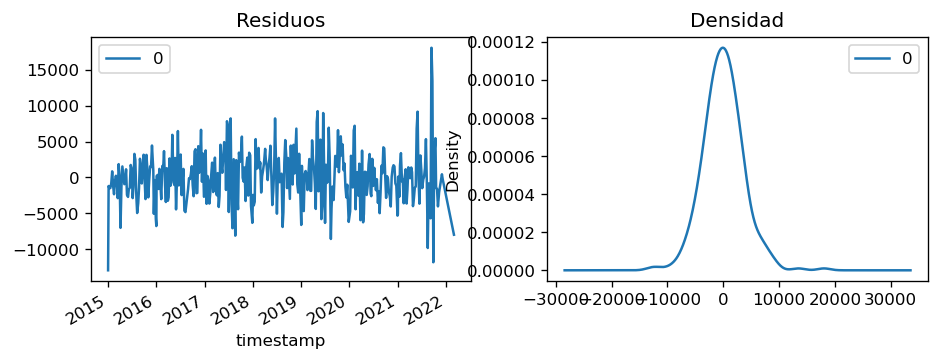

In [26]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2)
residuals.plot(title = "Residuos", ax = ax[0])
residuals.plot(kind = 'kde', title = 'Densidad', ax = ax[1])
plt.show()

El modelo es entrenado para cada valor o lag empleando sus valores previos con esta opción hasta la cantidad indicada por la primera componente AR, pero no está prediciendo el futuro, por lo que hace que parezca falsamente bien, pues se trata de aprendizaje supervisado. Esta comprobación se debe hacer mediante **cross-validation** para que sea lo más fiable posible.

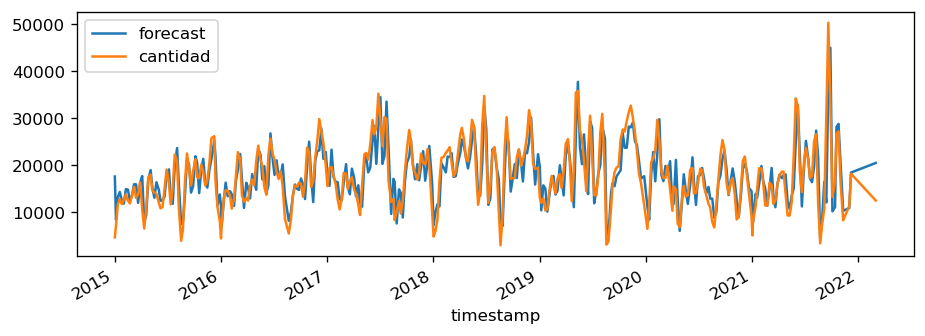

In [27]:
# Actual vs Fitted
model_fit.plot_predict(dynamic = False) # dynamic = False hace que se usen los mismos valores del train para predecir.
plt.show()

# ===========================================================

### Modelo SARIMA

El test de SARIMA si que tiene estacionalidad. Para este caso se va a emplear el algoritmo de **auto-arima**, que es un optimizador que buscará crear el modelo que mejor represente a la serie, reproduciendo los tres coeficientes con el mejor AIC posible.

Se pueden establecer las condiciones de las variables como hiperparámetros; valores iniciales de valoración **(p, d, q)**, valores finales de valoración **(P, D, Q)**, la fecuencia **"m"** y otros factores como el criterio **"test"** para encontrar el "d" óptimo.

- Como regla general, **"D"** nunca excederá 1 y **"d + D"** nunca excederá 2.
- Cuando se dividan los datos para realizar un adecuado test, debido a que se debe construir un modelo sin interrupciones y con coherencia lineal, los datos no pueden desordenarse, sino que el modelo debe cortarse pero mantenerse;

In [5]:
train, test = divide(df, 0.95) # Función propia, mirar arriba.
print(len(train))
print(len(test))

344
18


Y ahora construyendo el mejor modelo con auto-arima.

In [6]:
# Seasonal - fit stepwise auto-ARIMA
training_start = time.perf_counter() # inicia entrenamiento
seasonal_model = pm(train[['cantidad']],
                    start_p = 1, start_q = 1,
                    test = 'adf',                  # Usa adftest para encontrar el 'd' optimo
                    max_p = 2, max_q = 2, m = 53,  # m = 4 es para trimestrales, m = 12 para ciclos mensuales y m = 1 para ciclos anuales
                    start_P = 0, seasonal = True,  # Para activar la estacionalidad y poder predecir el modelo
                    d = None, D = 1, trace = True, # d = None deja que el modelo busque el mejor 'd'
                    error_action = 'ignore',
                    suppress_warnings = True,
                    stepwise = True)
training_end = time.perf_counter() # finaliza entrenamiento
train_time = training_end - training_start
print("Time consumed in training: %.3f" % train_time, "seconds")
seasonal_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[53] intercept   : AIC=inf, Time=22.81 sec
 ARIMA(0,0,0)(0,1,0)[53] intercept   : AIC=6047.995, Time=0.23 sec
 ARIMA(1,0,0)(1,1,0)[53] intercept   : AIC=5803.915, Time=4.98 sec
 ARIMA(0,0,1)(0,1,1)[53] intercept   : AIC=inf, Time=13.70 sec
 ARIMA(0,0,0)(0,1,0)[53]             : AIC=6046.302, Time=0.75 sec
 ARIMA(1,0,0)(0,1,0)[53] intercept   : AIC=5841.081, Time=0.56 sec
 ARIMA(1,0,0)(2,1,0)[53] intercept   : AIC=5789.540, Time=14.90 sec
 ARIMA(1,0,0)(2,1,1)[53] intercept   : AIC=inf, Time=38.83 sec
 ARIMA(1,0,0)(1,1,1)[53] intercept   : AIC=inf, Time=33.42 sec
 ARIMA(0,0,0)(2,1,0)[53] intercept   : AIC=6039.870, Time=9.87 sec
 ARIMA(2,0,0)(2,1,0)[53] intercept   : AIC=5733.071, Time=20.70 sec
 ARIMA(2,0,0)(1,1,0)[53] intercept   : AIC=5745.627, Time=5.92 sec
 ARIMA(2,0,0)(2,1,1)[53] intercept   : AIC=inf, Time=102.54 sec
 ARIMA(2,0,0)(1,1,1)[53] intercept   : AIC=inf, Time=12.66 sec
 ARIMA(2,0,1)(2,1,0)[53] intercept   : A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  344
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 53)   Log Likelihood               -2861.175
Date:                            Sun, 07 Aug 2022   AIC                           5732.350
Time:                                    01:51:50   BIC                           5750.717
Sample:                                         0   HQIC                          5739.708
                                            - 344                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1433      0.067     17.189      0.000       1.013       1.274
ar.L2         -0.4228      0.067     -6.340      0.000      -0.554      -0.292
ar.S.L53      -0.4985      0.081     -6.126      0.000      -0.658      -0.339
ar.S.L106     -0.2656      0.077     -3.431      0.001      -0.417      -0.114
sigma2      2.432e+07   6.85e-10   3.55e+16      0.000    2.43e+07    2.43e+07
===================================================================================
Ljung-Box (L1) (Q):                  11.86   Jarque-Bera (JB):                 9.82
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.08   Skew:                            -0.17
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.86e+32. Standard errors may be unstable.
"""

Gracias a la función propia **plot_diagnostics** de ARIMA, se pueden extraer una serie de conclusiones y un análisis más profundo:

- Arriba-izquierda; los errores fluctúan entorno al cero y tienen una varianza homogénea pero muy desviada hacia valores positivos.
- Arriba-derecha; la densidad de los datos encaja aproximadamente respecto de la normal.
- Abajo-izquierda; todos los puntos deben encajar en la línea predicción/realidad. Los puntos excéntricos en los extremos implican cierto sesgo del modelo.
- Abajo-derecha; el correlograma con puntos fuera de la tendencia revela que hay cierta autocorrelación. Esta autocorrelación significa que hay patrones residuales en el error que no es capaz de explicar el modelo, lo cual indica hacen falta variables exógenas que puedan completarlo.

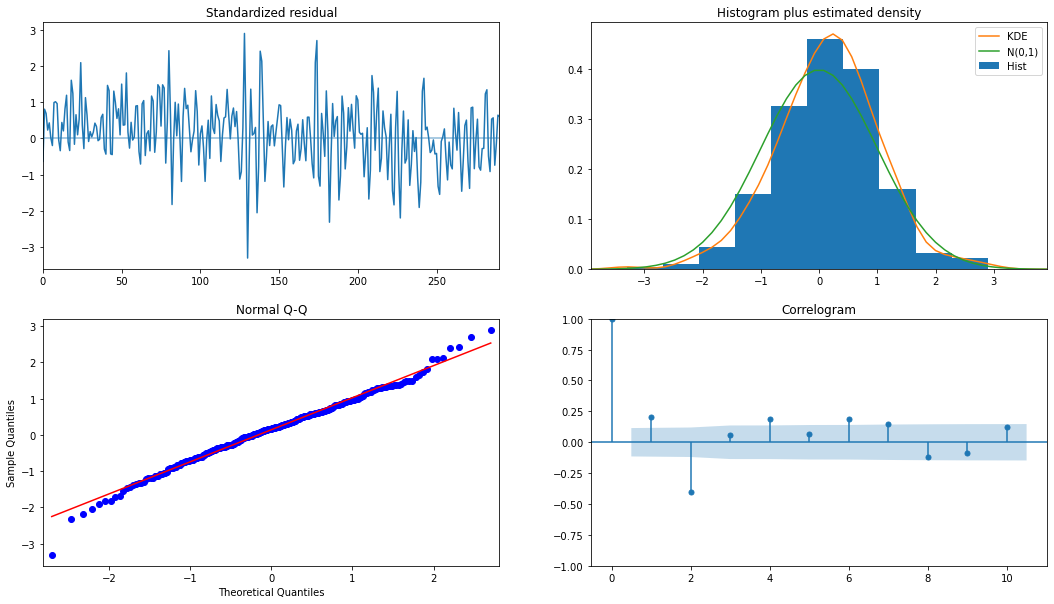

In [7]:
seasonal_model.plot_diagnostics(figsize = (18, 10))
plt.show()

Representación de la predicción, siendo el área gris claro un espacio de incertidumbre en el que se pueden mover los datos realmente.

Time consumed in prediction: 0.140 seconds


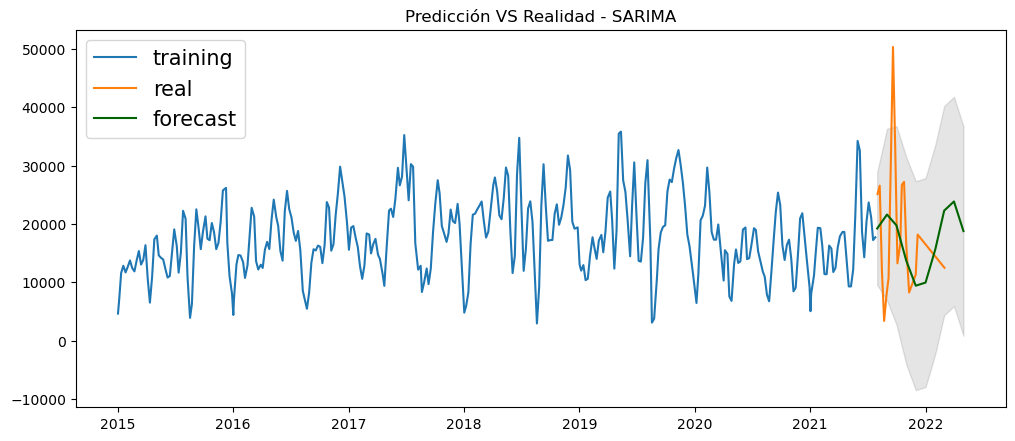

In [8]:
# Forecast
n_periods = 10
prediction_start = time.perf_counter() # inicia prediccion
fitted, confint = seasonal_model.predict(n_periods = n_periods, return_conf_int = True)
prediction_end = time.perf_counter() # finaliza prediccion
prediction_time = prediction_end - prediction_start
print("Time consumed in prediction: %.3f" % prediction_time, "seconds")
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq = 'MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index = index_of_fc)
lower_series = pd.Series(confint[:, 0], index = index_of_fc)
upper_series = pd.Series(confint[:, 1], index = index_of_fc)

# Plot
plt.figure(figsize = (12, 5), dpi = 100)
plt.plot(train['cantidad'], label = 'training')
plt.plot(test['cantidad'], label = 'real')
plt.plot(fitted_series, color = 'darkgreen', label = 'forecast')
plt.fill_between(lower_series.index, 
                 lower_series, upper_series, 
                 color = 'k', alpha = .1)
plt.title("Predicción VS Realidad - SARIMA")
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

Estadísticos importantes.

In [21]:
forecast_accuracy(fitted, test['cantidad'])

<ipython-input-2-4b627fe3e394>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis = 1)
<ipython-input-2-4b627fe3e394>:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis = 1)
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 relea

{'mape': 0.320057818384332,
 'me': 1420.8446507517237,
 'mae': 4358.979095175113,
 'mpe': 0.225851594788867,
 'rmse': 6065.852873230563,
 'acf1': 0.3458562146163687,
 'corr': 0.7493216844507403,
 'minmax': 0.20766177650938045}

# ===========================================================

### Modelo SARIMAX

El código a continuación pretende comprobar la validez de la variable exógena propuesta previamente. El impacto del confinamiento por el SARS-CoV durante casi dos años en forma de una variable booleana 1, si hay confinamiento, 0 en caso contrario.

In [4]:
df['crisis_oferta'] = 0 # Se va a crear una columna de crisis de oferta para intentar reflejar el efecto del covid
df['crisis_oferta'].loc[(df.index > '2020-03-14') & (df.index < '2021-05-01')] = 1

train, test = divide(df, 0.95) # funcion propia
print(len(train))
print(len(test))

344
18


D:\Python\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Si el modelo fuese más regular en su estacionalidad, se podría desarrollar una variable exógena extra basada en dicha estacionalidad que apoyase a la predicción. Pero en este caso, la venta de productos resulta ser tan irregular que la estacionalidad sería casi ruido.

Y ahora construyendo el mejor modelo con auto-arima.

In [5]:
# Seasonal - fit stepwise auto-ARIMA
training_start = time.perf_counter() # inicia entrenamiento
seasonal_exo_model = pm(train[['cantidad']], exogenous = train[['crisis_oferta']],
                        start_p = 0, start_q = 0,
                        start_P = 0, start_Q = 0,
                        test = 'adf',                 # usa adftest para encontrar el 'd' optimo
                        max_p = 2, max_q = 2,
                        max_P = 2, max_Q = 2,
                        n_fits = 50,
                        m = 53, # m = 4 es para trimestrales, m = 12 para ciclos mensuales y m = 1 para ciclos anuales
                        seasonal = True, # para activar la estacionalidad y poder predecir el modelo
                        d = None, D = 1, trace = True, # d = None deja que el modelo busque el mejor 'd'
                        error_action = 'ignore',
                        suppress_warnings = True,
                        stepwise = True)
training_end = time.perf_counter() # finaliza entrenamiento
train_time = training_end - training_start
print("Time consumed in training: %.3f" % train_time, "seconds")
seasonal_exo_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[53] intercept   : AIC=6007.242, Time=0.99 sec
 ARIMA(1,0,0)(1,1,0)[53] intercept   : AIC=5804.476, Time=6.83 sec
 ARIMA(0,0,1)(0,1,1)[53] intercept   : AIC=5680.098, Time=31.68 sec
 ARIMA(0,0,0)(0,1,0)[53]             : AIC=7371.602, Time=0.24 sec
 ARIMA(0,0,1)(0,1,0)[53] intercept   : AIC=5715.634, Time=3.72 sec
 ARIMA(0,0,1)(1,1,1)[53] intercept   : AIC=inf, Time=28.32 sec
 ARIMA(0,0,1)(0,1,2)[53] intercept   : AIC=5704.370, Time=30.63 sec
 ARIMA(0,0,1)(1,1,0)[53] intercept   : AIC=5705.392, Time=9.25 sec
 ARIMA(0,0,1)(1,1,2)[53] intercept   : AIC=inf, Time=109.50 sec
 ARIMA(0,0,0)(0,1,1)[53] intercept   : AIC=5991.324, Time=5.40 sec
 ARIMA(1,0,1)(0,1,1)[53] intercept   : AIC=inf, Time=38.69 sec
 ARIMA(0,0,2)(0,1,1)[53] intercept   : AIC=5585.550, Time=39.95 sec
 ARIMA(0,0,2)(0,1,0)[53] intercept   : AIC=5641.146, Time=5.12 sec
 ARIMA(0,0,2)(1,1,1)[53] intercept   : AIC=inf, Time=65.14 sec
 ARIMA(0,0,2)(0,1,2)[53] interc

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  344
Model:             SARIMAX(0, 0, 2)x(0, 1, [1], 53)   Log Likelihood               -2786.775
Date:                              Sun, 14 Aug 2022   AIC                           5585.550
Time:                                      12:28:42   BIC                           5607.590
Sample:                                           0   HQIC                          5594.380
                                              - 344                                         
Covariance Type:                                opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept       592.8348    434.716      1.364      0.173    -259.194    1444.863
crisis_oferta -5556.7736    710.757     -7.818      0.000   -6949.832   -4163.715
ma.L1             1.5593      0.047     32.986      0.000       1.467       1.652
ma.L2             0.6148      0.046     13.381      0.000       0.525       0.705
ma.S.L53         -0.4718      0.068     -6.963      0.000      -0.605      -0.339
sigma2         1.134e+07      0.191   5.94e+07      0.000    1.13e+07    1.13e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.21   Jarque-Bera (JB):                 1.49
Prob(Q):                              0.27   Prob(JB):                         0.47
Heteroskedasticity (H):               1.31   Skew:                            -0.11
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.91e+23. Standard errors may be unstable.
"""

En el diagnóstico se aprecia cómo;
-	Arriba-izquierda; los errores fluctúan entorno al cero mucho mejor que antes.
-	Arriba-derecha; la densidad de los datos sigue encajando con la normal, aunque se ha desviado un poco más que antes.
-	Abajo-izquierda; en este caso la excentricidad de los extremos ha aumentado, representando un sesgo aún mayor.
-	Abajo-derecha; en este caso no hay casi puntos fuera, por lo que la autocorrelación ha sido aún menor. Esto indica que los residuos tienen menos información y el modelo ha tocado techo en lo que a explicación se refiere.

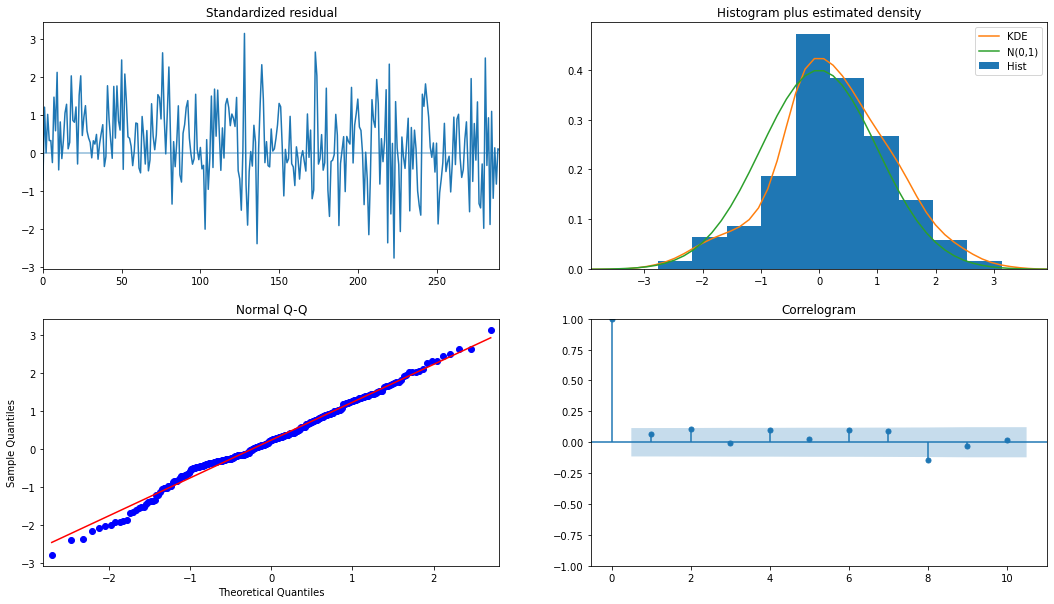

In [6]:
seasonal_exo_model.plot_diagnostics(figsize = (18, 10))
plt.show()

Representación de la predicción.

D:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Time consumed in prediction: 0.055 seconds


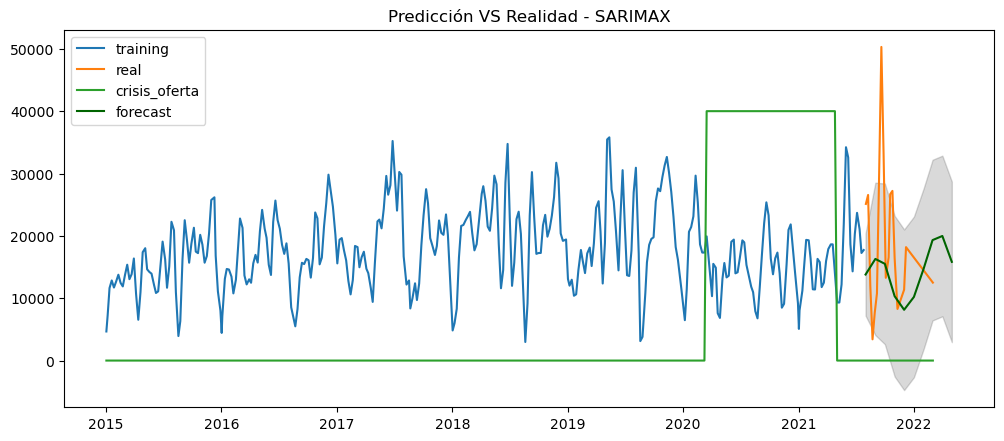

In [7]:
# Forecast
n_periods = 10
prediction_start = time.perf_counter() # inicia prediccion
fitted, confint = seasonal_exo_model.predict(n_periods = n_periods, 
                                             exogenous = np.ones(n_periods).reshape(-1, 1), # la variable exogena se asume que va a ser 1 (aun con covid)
                                             return_conf_int = True)
#fitted, confint = seasonal_model.predict(n_periods = len(test), return_conf_int = True)
prediction_end = time.perf_counter() # finaliza prediccion
prediction_time = prediction_end - prediction_start
print("Time consumed in prediction: %.3f" % prediction_time, "seconds")

# make series for plotting purpose
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq = 'MS') # selecciona la fecha de inicio del test
#index_of_fc = pd.date_range(train.index[-1], periods = len(test), freq = 'MS') # selecciona la fecha de inicio del test
fitted_series = pd.Series(fitted, index = index_of_fc)
lower_series = pd.Series(confint[:, 0], index = index_of_fc)
upper_series = pd.Series(confint[:, 1], index = index_of_fc)

# Plot
plt.figure(figsize = (12, 5), dpi = 100)
plt.plot(train['cantidad'], label = 'training')
plt.plot(test['cantidad'], label = 'real')
plt.plot(df['crisis_oferta'] * 40000, label = 'crisis_oferta')
plt.plot(fitted_series, label = 'forecast', color = 'darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, upper_series, 
                 color = 'k', alpha = .15)
plt.title('Predicción VS Realidad - SARIMAX')
plt.legend(loc = 'upper left', fontsize = 10)
plt.show()

Estadísticos importantes.

In [8]:
forecast_accuracy(fitted, test['cantidad'])

<ipython-input-2-4b627fe3e394>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis = 1)
<ipython-input-2-4b627fe3e394>:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis = 1)
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 relea

{'mape': 0.49969011756777454,
 'me': -6818.135158149953,
 'mae': 9521.697584799927,
 'mpe': 0.01712914363900728,
 'rmse': 12929.023273518274,
 'acf1': 0.4275193725692196,
 'corr': 0.7935462011928734,
 'minmax': 0.3533312256139711}

# ===========================================================

### Modelo SARIMAX para una prediccion mensual

Por último se propone un estudio extra del comportamiento de un posible modelo estudiando los datos de ventas mensuales en vez de semanales, aunque en este caso se va a disponer de mucha menos información que antes por ser diluida en períodos mayores.

In [35]:
# los tres dataset
df_clientes = pd.read_csv(ROOT + "dClientes.csv", delimiter = ',')
df_dim_pedidos = pd.read_csv(ROOT + "dPedidos.csv", delimiter = ',')
df_pedidos = pd.read_csv(ROOT + "fPedidos.csv", delimiter = ',')
df_clientes = df_clientes.dropna()
df_dim_pedidos = df_dim_pedidos.dropna()
df_pedidos = df_pedidos.dropna()

# selecciona el id y la cantidad de pedidos en tabla auxiliar
df_aux = pd.DataFrame()
df_aux['cantidad'] = df_pedidos.groupby('digit_digit_sm_idpedido')['digit_digit_sm_cantidad'].sum()
df_aux = df_aux.reset_index() # groupby convierte la variable clave en index, por lo que hay que desconvertir

# crea un dataframe para unirlo todo
df = pd.DataFrame()
df['timestamp'] = pd.to_datetime(df_dim_pedidos['digit_digit_sm_fechapedido']) # extrae fechas
df = df[df['timestamp'] > '2015-01-01'] # a partir del año del comportamiento actual
#df = df[df['timestamp'] < '2021-06-01'] # omitiendo los picos de ventas post-covid
df['id_pedido'] = df_dim_pedidos['digit_digit_sm_idpedido'] # extrae id para añadir la informacion del pedido
df = df.join(df_aux.set_index('digit_digit_sm_idpedido'), on = 'id_pedido') # añade informacion de pedido
df = df.drop(['id_pedido'], axis = 1) # elimina la columna auxiliar de los pedidos
df = df.sort_values(by = 'timestamp', ascending = True) # ordena segun el timestamp
#df['crisis_oferta'] = 0 # Se va a crear una columna de crisis de oferta para intentar reflejar el efecto del covid
#df['crisis_oferta'].loc[(df['timestamp'] > '2020-03-14') & (df['timestamp'] < '2021-05-01')] = 1
df['year'] = df['timestamp'].dt.year # una columna para el año
#====================================================================================
df['month'] = df['timestamp'].dt.month # una columna para el mes
#====================================================================================
df = df.set_index(['month', 'year']) # establece semanas y años de index para agrupar segun ellos
df['cantidad'] = df.groupby(['month', 'year'])['cantidad'].sum() # agrupa los pedidos que se produjeron la misma semana del año
df = df[~ df.index.duplicated(keep = 'first')] # elimina las replicas que se han producido en la agrupacion anterior
df = df.reset_index().set_index(['timestamp']) # cambia timestamp de index
df = df.drop(['month', 'year'], axis = 1) # elimina las columnas innecesarias
df['cantidad'] = df['cantidad'].rolling(1, center = True, closed = 'both').mean() # suavizado mediante Moving Average
# elimina nan
print(df.shape)
df = df.dropna()
print(df.shape)
df = df[df['cantidad'] > 0] # elimina negativos y ceros para poder aplicar seasonal
df['cantidad'] = df['cantidad'].rolling(1, center = True, closed = 'both').mean() # suavizado mediante Moving Average
df

(85, 1)
(85, 1)


,cantidad
timestamp,
2015-01-02,54184.00
2015-02-02,53465.75
2015-03-02,56065.50
2015-04-02,60572.50
2015-05-01,58935.50
...,...
2021-09-02,85545.25
2021-10-02,105834.25
2021-11-01,81092.50


Por el comportamiento distinto de este modelo, es recomendable realizar de nuevo el estidio de la estacionalidad, y de hecho en este caso hay una discrepancia entre los dos test, ya que no está tan claro el comportamiento estacional. ADF indica que ya no es estacionario.

In [36]:
# Se necesita diferenciacion solo si el comportamiento es no estacionario (d = 0)
result = adfuller(df['cantidad'], autolag = 'AIC')
if result[1] > 0.05:
    print('Según ADF, el modelo es no estacionario')
else:
    print('Según ADF, el modelo es estacionario')
    
# KPSS Test
# Otra opinion.
result = kpss(df['cantidad'], regression = 'c')
if result[1] > 0.05: # Si el P-value es no significativo
    print('Según KPSS, el modelo es estacionario')
else:
    print('Según KPSS, el modelo es no estacionario')

Según ADF, el modelo es no estacionario
Según KPSS, el modelo es estacionario


D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Y ahora construyendo el mejor modelo con auto-arima.

In [37]:
# Seasonal - fit stepwise auto-ARIMA
training_start = time.perf_counter() # inicia entrenamiento
seasonal_exo_model = pm(train[['cantidad']], exogenous = train[['crisis_oferta']],
                        start_p = 0, start_q = 0,
                        start_P = 0, start_Q = 0,
                        test = 'adf',                 # usa adftest para encontrar el 'd' optimo
                        max_p = 2, max_q = 2,
                        max_P = 2, max_Q = 2,
                        n_fits = 50,
                        m = 48, # m = 4 es para trimestrales, m = 12 para ciclos mensuales y m = 1 para ciclos anuales
                        seasonal = False, # EN ESTE CASO ES NO ESTACIONARIO
                        d = None, D = 1, trace = True, # d = None deja que el modelo busque el mejor 'd'
                        error_action = 'ignore',
                        suppress_warnings = True,
                        stepwise = True)
training_end = time.perf_counter() # finaliza entrenamiento
train_time = training_end - training_start
print("Time consumed in training: %.3f" % train_time, "seconds")
seasonal_exo_model.summary()

D:\Python\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (48) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9378.278, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6797.888, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=6758.289, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6654.765, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6655.729, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6618.717, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6653.970, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6624.238, Time=0.14 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 1.185 seconds
Time consumed in training: 1.363 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  344
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -3303.358
Date:                Wed, 03 Aug 2022   AIC                           6618.717
Time:                        04:58:57   BIC                           6641.760
Sample:                             0   HQIC                          6627.895
                                - 344                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
crisis_oferta  1.477e+04    720.844     20.490      0.000    1.34e+04    1.62e+04
ar.L1             1.6030      0.071     22.716      0.000       1.465       1.741
ar.L2            -0.6044      0.070     -8.682      0.000      -0.741      -0.468
ma.L1            -0.1355      0.059     -2.310      0.021      -0.251      -0.021
ma.L2            -0.7260      0.035    -20.518      0.000      -0.795      -0.657
sigma2         1.294e+07      0.406   3.18e+07      0.000    1.29e+07    1.29e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.95   Jarque-Bera (JB):                52.33
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               2.55   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+22. Standard errors may be unstable.
"""

En el diagnóstico se aprecia cómo;

- Arriba-izquierda; los errores fluctúan entorno al cero de manera regular pero poco homogénea, mostrando un comportamiento distinto.
- Arriba-derecha; sin discrepancia entre las normales.
- Abajo-izquierda; en este caso la excentricidad de los extremos es mucho mayor que los otros, teniendo los resultados un mayor sesgo.
- Abajo-derecha; en este caso no hay casi puntos fuera, por lo que los residuos filtran poca información.

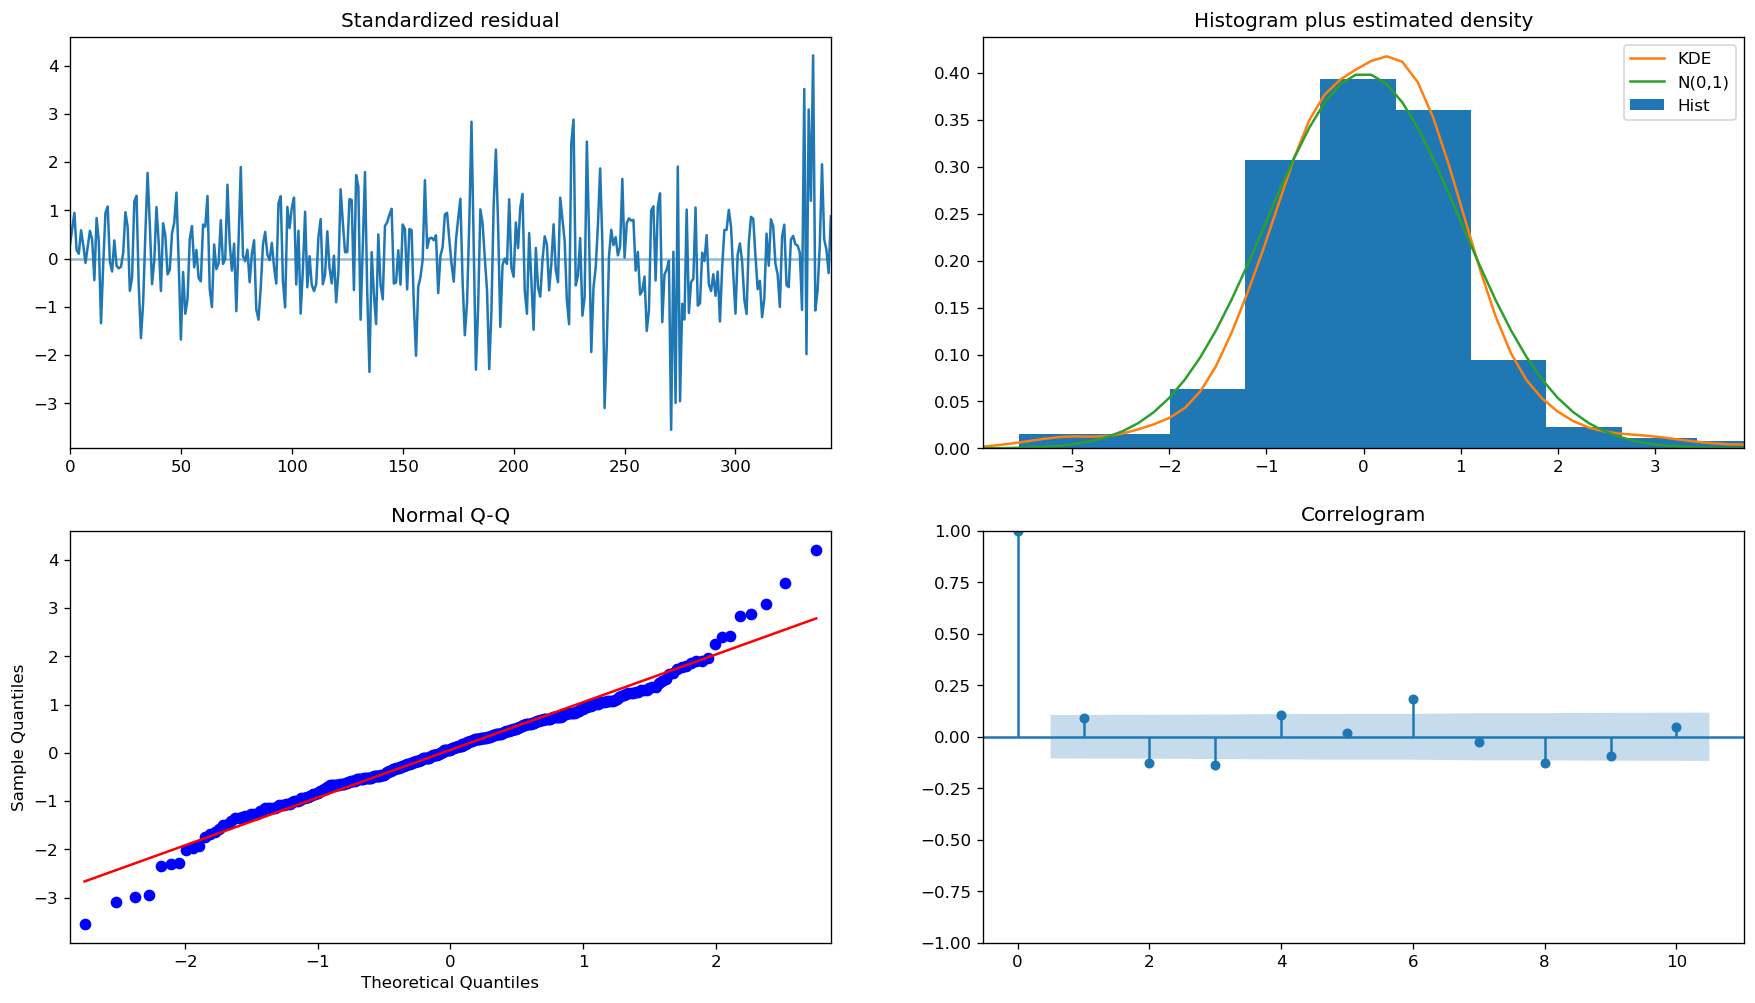

In [38]:
seasonal_exo_model.plot_diagnostics(figsize = (18, 10))
plt.show()

Representación de la predicción.

D:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Time consumed in prediction: 0.009 seconds


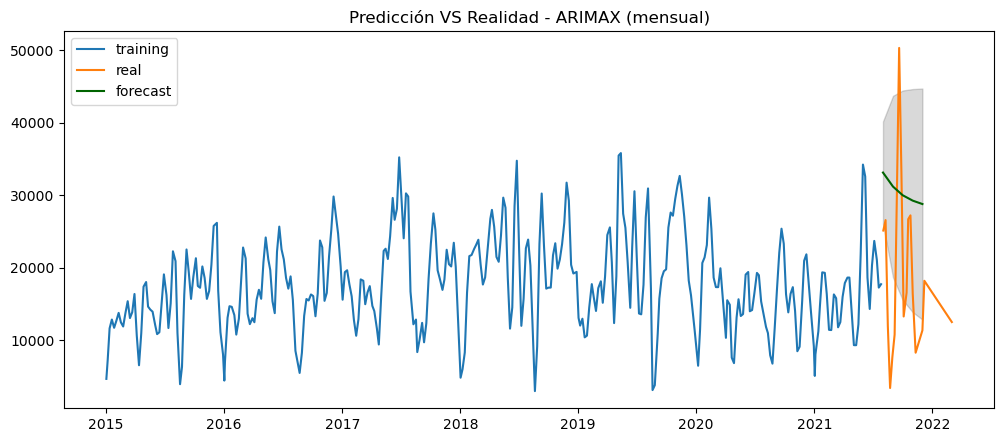

In [39]:
# Forecast
n_periods = 5
prediction_start = time.perf_counter() # inicia prediccion
fitted, confint = seasonal_exo_model.predict(n_periods = n_periods, 
                                             exogenous = np.ones(n_periods).reshape(-1, 1), # la variable exogena se asume que va a ser 1 (aun con covid)
                                             return_conf_int = True)
#fitted, confint = seasonal_model.predict(n_periods = len(test), return_conf_int = True)
prediction_end = time.perf_counter() # finaliza prediccion
prediction_time = prediction_end - prediction_start
print("Time consumed in prediction: %.3f" % prediction_time, "seconds")

# make series for plotting purpose
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq = 'MS') # selecciona la fecha de inicio del test
#index_of_fc = pd.date_range(train.index[-1], periods = len(test), freq = 'MS') # selecciona la fecha de inicio del test
fitted_series = pd.Series(fitted, index = index_of_fc)
lower_series = pd.Series(confint[:, 0], index = index_of_fc)
upper_series = pd.Series(confint[:, 1], index = index_of_fc)

# Plot
plt.figure(figsize = (12, 5), dpi = 100)
plt.plot(train['cantidad'], label = 'training')
plt.plot(test['cantidad'], label = 'real')
plt.plot(fitted_series, label = 'forecast', color = 'darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, upper_series, 
                 color = 'k', alpha = .15)
plt.title('Predicción VS Realidad - ARIMAX (mensual)')
plt.legend(loc = 'upper left', fontsize = 10)
plt.show()

Estadísticos importantes.

In [40]:
forecast_accuracy(fitted, test['cantidad'])

<ipython-input-15-4b627fe3e394>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis = 1)
<ipython-input-15-4b627fe3e394>:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis = 1)
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Python\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 rel

{'mape': 2.4687630342937825,
 'me': 15520.432225089924,
 'mae': 15520.432225089924,
 'mpe': 2.4687630342937825,
 'rmse': 17458.05727788766,
 'acf1': 0.4327809375313827,
 'corr': 0.8707494496625935,
 'minmax': 0.5216689466502131}